# Lab 5: Feature Selection 

This notebook builds on top of Lab 4 by introducing feature selection into the process of selecting the best classifier for a binary classification problem.

The feature selection method applied here is Recursive Feature Elimination (RFE) as demonstrated in the tutorial at https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/.

In this demonstration we use a modified version of the seeds data set (see https://archive.ics.uci.edu/ml/datasets/seeds), which is the same data set used in Lab 4.

## A. Preparation

### Import Python modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing #needed for scaling attributes to the interval [0,1]

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_classif, SelectPercentile, chi2
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### Load and prepare the dataset for training and evaluation
Feel free to apply any other pre-processing technique at this point.

In [2]:
lab5_df = pd.read_csv("./winequality_red.csv")
lab5_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## TASK 1

In [3]:
lab5_df['quality'].value_counts() 

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [4]:
# target attribute
target_attribute_name = 'quality'
target = lab5_df[target_attribute_name]

# predictor attributes
predictors = lab5_df.drop(target_attribute_name, axis=1).values

# scale all predictor values to the range [0, 1]
# the target is in a multiclass type
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

Split the data set into a training (80%) and test (20%) data sets.

In [5]:
# pepare independent stratified data sets for training and test of the final model
predictors_train, predictors_test, target_train, target_test = train_test_split(
    predictors, target, test_size=0.20, shuffle=True, stratify=target)

## B. Feature Selection

#### 1. Apply RFE with SVM for selecting the best features

In [6]:
# create a base classifier used to evaluate a subset of attributes
estimatorSVM = svm.SVR(kernel="linear")
selectorSVM = RFE(estimatorSVM, 3)
selectorSVM = selectorSVM.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorSVM.support_)
print(selectorSVM.ranking_)

[False  True False False False False False False False  True  True]
[3 1 9 5 2 8 6 4 7 1 1]


#### 2. Apply RFE with Logistic Regression for selecting the best features

In [7]:
# create a base classifier used to evaluate a subset of attributes
estimatorLR = LogisticRegression()
# create the RFE model and select 3 attributes
selectorLR = RFE(estimatorLR, 3)
selectorLR = selectorLR.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorLR.support_)
print(selectorLR.ranking_)

[False  True False False False False  True False False False  True]
[6 1 4 7 8 9 1 3 5 2 1]


## B. Evaluate on the Test Data Set

Apply the selectors to prepare training data sets only with the selected features

__Note:__ The same selectors are applied to the test data set. However, it is important that the test data set was not used by (it's invisible to) the selectors. 

In [8]:
predictors_train_SVMselected = selectorSVM.transform(predictors_train)
predictors_test_SVMselected = selectorSVM.transform(predictors_test)

In [9]:
predictors_train_LRselected = selectorLR.transform(predictors_train)
predictors_test_LRselected = selectorLR.transform(predictors_test)

### Train and evaluate SVM classifiers with both the selected features and all features 

Here we train three models:
* model1 - with the features selected by SVM
* model2 - with the features selected by Logistic Regression
* model3 - with all features (i.e. without feature selection)

In [10]:
classifier = svm.SVC()
#decision_function_shape ='ovr' is used by default::one-vs-rest= each class is predicted against the remaining classes

In [11]:
model1 = classifier.fit(predictors_train_SVMselected, target_train)
model1.score(predictors_test_SVMselected, target_test)

0.553125

In [12]:
model2 = classifier.fit(predictors_train_LRselected, target_train)
model2.score(predictors_test_LRselected, target_test)

0.5625

In [13]:
model3 = classifier.fit(predictors_train, target_train,)
#model3.score(predictors_test, target_test, gamma = auto)
model3.score(predictors_test, target_test)

0.56875

## C. Conclusion

We conclude that none of the three models gives good result. Indeed all scores are under 60% accuracy. However the use of predictors selected by Logistic Regression RFE gives best result.

## TASK 2

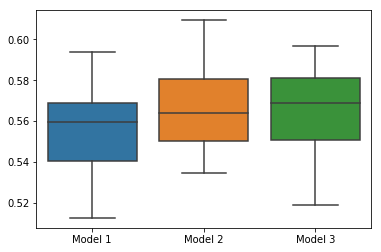

In [14]:

def boxplots(n_iterations):
    
    score1=[]
    score2=[]
    score3=[]
    
    for i in range(n_iterations):
        # pepare independent stratified data sets for training and test of the final model
        predictors_train, predictors_test, target_train, target_test = train_test_split(
        predictors, target, test_size=0.20, shuffle=True, stratify=target)

        # create a base classifier used to evaluate a subset of attributes (SVM)
        estimatorSVM = svm.SVR(kernel="linear")
        selectorSVM = RFE(estimatorSVM, 3)
        selectorSVM = selectorSVM.fit(predictors_train, target_train)


        # create a base classifier used to evaluate a subset of attributes (LR)
        estimatorLR = LogisticRegression()
        selectorLR = RFE(estimatorLR, 3)
        selectorLR = selectorLR.fit(predictors_train, target_train)

        # Apply the selectors to prepare training and test data  sets only with the selected features
        #SVM
        predictors_train_SVMselected = selectorSVM.transform(predictors_train)
        predictors_test_SVMselected = selectorSVM.transform(predictors_test)
        #LR
        predictors_train_LRselected = selectorLR.transform(predictors_train)
        predictors_test_LRselected = selectorLR.transform(predictors_test)

        #Train and evaluate SVM classifiers with both the selected features and all features
        classifier = svm.SVC()

        #Model1:with the features selected by SVM
        model1 = classifier.fit(predictors_train_SVMselected, target_train)
        score1=np.append(score1,model1.score(predictors_test_SVMselected, target_test))
        #Model2:with the features selected by Logistic Regression
        model2 = classifier.fit(predictors_train_LRselected, target_train)
        score2=np.append(score2,model2.score(predictors_test_LRselected, target_test))
        #Model3:with all features (i.e. without feature selection)
        model3 = classifier.fit(predictors_train, target_train,)
        score3=np.append(score3,model3.score(predictors_test, target_test))

    #Create a dataframe with scores
    Scores=pd.DataFrame([score1,score2,score3], index = ['Model 1' , 'Model 2', 'Model 3']) 
    #Boxplot
    sns.boxplot(data=Scores.T)# Scores is transposed in order to get one column per model scores   
    plt.show()  
    
boxplots(30)#Tries with different number of iterations

Compared to Task 1 results, it seems that we are not getting better results since the maximum accuracy got from Model 3 is slightly above 60% not realy far from Task1 results. We also see that Model 2 like for Task1 is giving (in Median) better results. But we remark that Models 2 and 3 are getting best results than Model1 in most of the cases.
One additional conclusion is about the variance of scores, even if model 2 is giving better results, it also presents a higher variance compared to Models 1 & 2.

## TASK 3

In [15]:
#Reset Predictiors in order to do the sclaing process inside the Pipelines
predictors = lab5_df.drop(target_attribute_name, axis=1).values

In [16]:
anova_classif = SelectKBest(f_classif, k=5)
selec_chi2 = SelectKBest(chi2, k=5)

clf = svm.SVC(kernel='linear')

Pipe1 = Pipeline([('scaler', preprocessing.MinMaxScaler()),('Anova', anova_classif), ('svc', clf)])
Pipe2 = Pipeline([('scaler', preprocessing.MinMaxScaler()),('Chi2', selec_chi2), ('svc', clf)])

# You can set the parameters using the names issued
# For instance, fit using a k of 3 in the SelectKBest
# and a parameter 'C' of the svm
Pipe1.set_params(Anova__k=3, svc__C=.1).fit(predictors, target)
#prediction = anova_svm.predict(X)
print('Pipe 1 Score is: %f' %Pipe1.score(predictors, target) )

Pipe2.set_params(Chi2__k=3, svc__C=.1).fit(predictors, target)
print('Pipe 1 Score is: %f' %Pipe2.score(predictors, target)) 


Pipe 1 Score is: 0.555347
Pipe 1 Score is: 0.542214
